# Pytorch Graph Auto Encoder

Resources:

- https://github.com/tkipf/gae
- https://github.com/zfjsail/gae-pytorch
- https://towardsdatascience.com/tutorial-on-variational-graph-auto-encoders-da9333281129
- https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
- https://linqs.soe.ucsc.edu/data
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [75]:
import os
import sys
import argparse

import numpy as np
from scipy import sparse as sp
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style="white")
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

from utils import mask_test_edges, preprocess_graph, get_roc_score

## Read the dataset

In [86]:
sys.path.append("/Users/eric/Code/tkipf_gae")

from gae import input_data

os.chdir("/Users/eric/Code/tkipf_gae/gae")

adj, features = input_data.load_data("cora")

In [92]:
assert isinstance(adj, sp.csr.csr_matrix)
assert isinstance(features, sp.lil.lil_matrix)

## Preprocess the data

In [50]:
n_nodes, feat_dim = features.shape

In [51]:
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

In [52]:
# Some preprocessing
adj_norm = preprocess_graph(adj)
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = torch.FloatTensor(adj_label.toarray())

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

features = torch.FloatTensor(np.array(features.todense()))

## Define the model

### Layers

In [53]:
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, dropout=0., act=F.relu):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.act = act
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj):
        input = F.dropout(input, self.dropout, self.training)
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        output = self.act(output)
        
        return output

    def __repr__(self):
        return "{0} ({1} -> {2})".format(self.__class__.__name__,
                                         self.in_features,
                                         self.out_features)
    

class InnerProductDecoder(nn.Module):
    """Decoder for using inner product for prediction."""

    def __init__(self, dropout, act=torch.sigmoid):
        super(InnerProductDecoder, self).__init__()
        self.dropout = dropout
        self.act = act

    def forward(self, z):
        z = F.dropout(z, self.dropout, training=self.training)
        adj = self.act(torch.mm(z, z.t()))
        
        return adj

### Model

In [54]:
class GCNModelVAE(nn.Module):
    def __init__(self, input_feat_dim, hidden_dim1, hidden_dim2, dropout):
        super(GCNModelVAE, self).__init__()
        self.gc1 = GraphConvolution(input_feat_dim, hidden_dim1, dropout, act=F.relu)
        self.gc2 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
        self.gc3 = GraphConvolution(hidden_dim1, hidden_dim2, dropout, act=lambda x: x)
        self.dc = InnerProductDecoder(dropout, act=lambda x: x)

    def encode(self, x, adj):
        hidden1 = self.gc1(x, adj)
        mu = self.gc2(hidden1, adj)
        logvar = self.gc3(hidden1, adj)
        
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, adj):
        mu, logvar = self.encode(x, adj)
        z = self.reparameterize(mu, logvar)
        
        return self.dc(z), mu, logvar

### Loss function

In [55]:
def loss_function(preds, labels, mu, logvar, n_nodes, norm, pos_weight):
    BCE = norm * F.binary_cross_entropy_with_logits(preds, labels, pos_weight=pos_weight)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 / n_nodes * torch.mean(torch.sum(
        1 + 2 * logvar - mu.pow(2) - logvar.exp().pow(2), 1))
    
    return BCE + KLD

## Training

In [58]:
model = GCNModelVAE(feat_dim, 32, 16, 0)
optimizer = optim.Adam(model.parameters(), lr=.01)

In [59]:
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    recovered, mu, logvar = model(features, adj_norm)

    pos_weight = torch.FloatTensor([pos_weight])

    loss = loss_function(preds=recovered, labels=adj_label,
                         mu=mu, logvar=logvar, n_nodes=n_nodes,
                         norm=norm, pos_weight=pos_weight)

    loss.backward()

    cur_loss = loss.item()
    optimizer.step()

    hidden_emb = mu.data.numpy()
    roc_curr, ap_curr = get_roc_score(hidden_emb, adj_orig, val_edges, val_edges_false)

    print(
        "Epoch:", '%04d' % (epoch + 1),
        "train_loss=", "{:.5f}".format(cur_loss),
        "val_ap=", "{:.5f}".format(ap_curr)
    )

Epoch: 0001 train_loss= 1.74277 val_ap= 0.74262
Epoch: 0002 train_loss= 1.46373 val_ap= 0.68985
Epoch: 0003 train_loss= 1.27372 val_ap= 0.68043
Epoch: 0004 train_loss= 1.11735 val_ap= 0.68532
Epoch: 0005 train_loss= 0.96673 val_ap= 0.69801
Epoch: 0006 train_loss= 0.84475 val_ap= 0.72067
Epoch: 0007 train_loss= 0.76958 val_ap= 0.75283
Epoch: 0008 train_loss= 0.73591 val_ap= 0.77705
Epoch: 0009 train_loss= 0.71665 val_ap= 0.77093
Epoch: 0010 train_loss= 0.71117 val_ap= 0.75924
Epoch: 0011 train_loss= 0.70827 val_ap= 0.77704
Epoch: 0012 train_loss= 0.69080 val_ap= 0.81920
Epoch: 0013 train_loss= 0.66911 val_ap= 0.85338
Epoch: 0014 train_loss= 0.65115 val_ap= 0.86224
Epoch: 0015 train_loss= 0.63046 val_ap= 0.86533
Epoch: 0016 train_loss= 0.60808 val_ap= 0.87303
Epoch: 0017 train_loss= 0.58368 val_ap= 0.87754
Epoch: 0018 train_loss= 0.56540 val_ap= 0.87894
Epoch: 0019 train_loss= 0.54979 val_ap= 0.87925
Epoch: 0020 train_loss= 0.54564 val_ap= 0.87758
Epoch: 0021 train_loss= 0.54625 val_ap= 

## Visualizing embeddings

In [60]:
tsne = TSNE(n_components=2)
hidden_emb_tsne = tsne.fit_transform(hidden_emb)

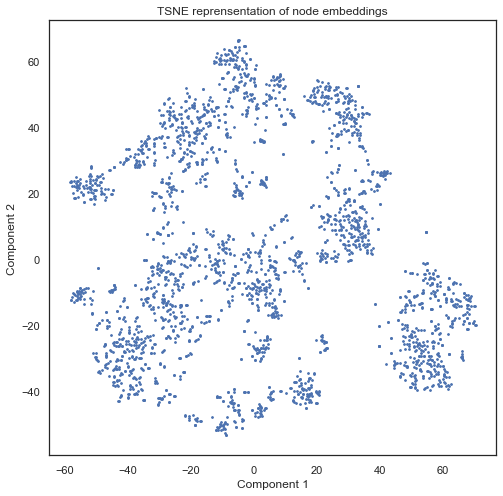

In [76]:
plt.figure(figsize=(8, 8))
plt.scatter(hidden_emb_tsne[:, 0], hidden_emb_tsne[:, 1], s=3)

plt.title("TSNE reprensentation of node embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()